# Column Generation

### Cutting Stock exemple:

There is a number of standard rolls, all with the same width $W$, and there are $m$ orders for items that must be cut out of the standard rolls. Order $j$ requires $b_j$ items, all with the same width $w_j$.

The goal is to produce all items by using a minimum number of standard rolls.


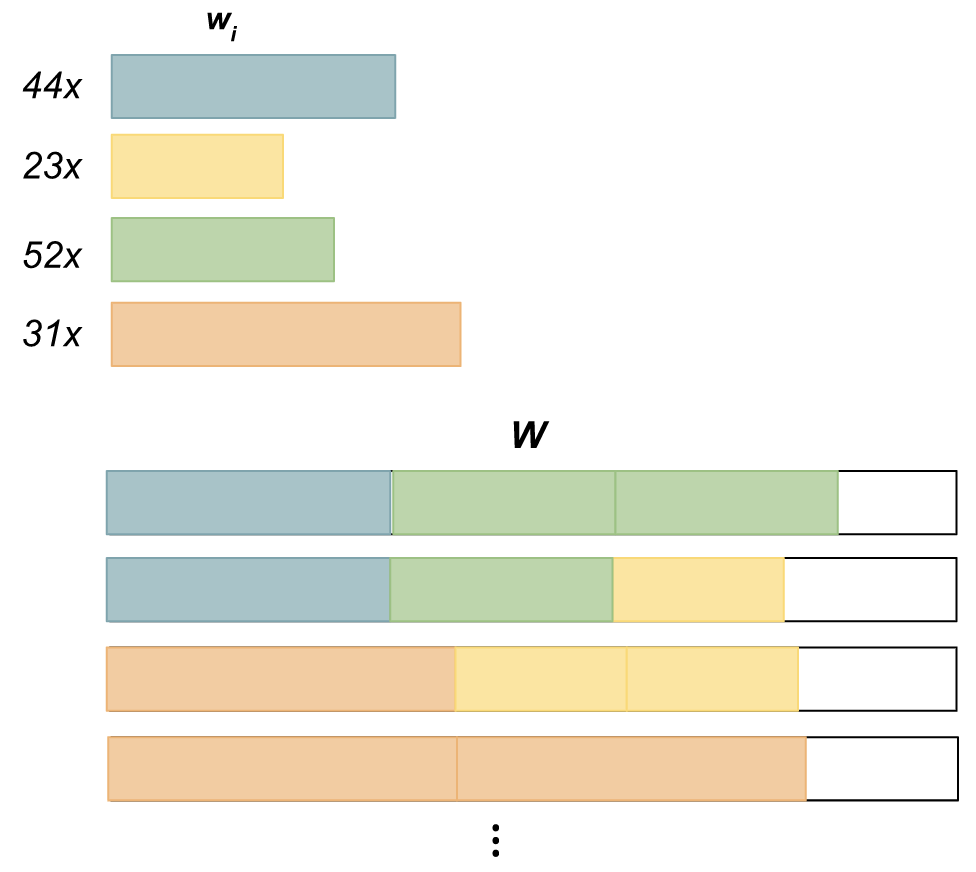

<!-- 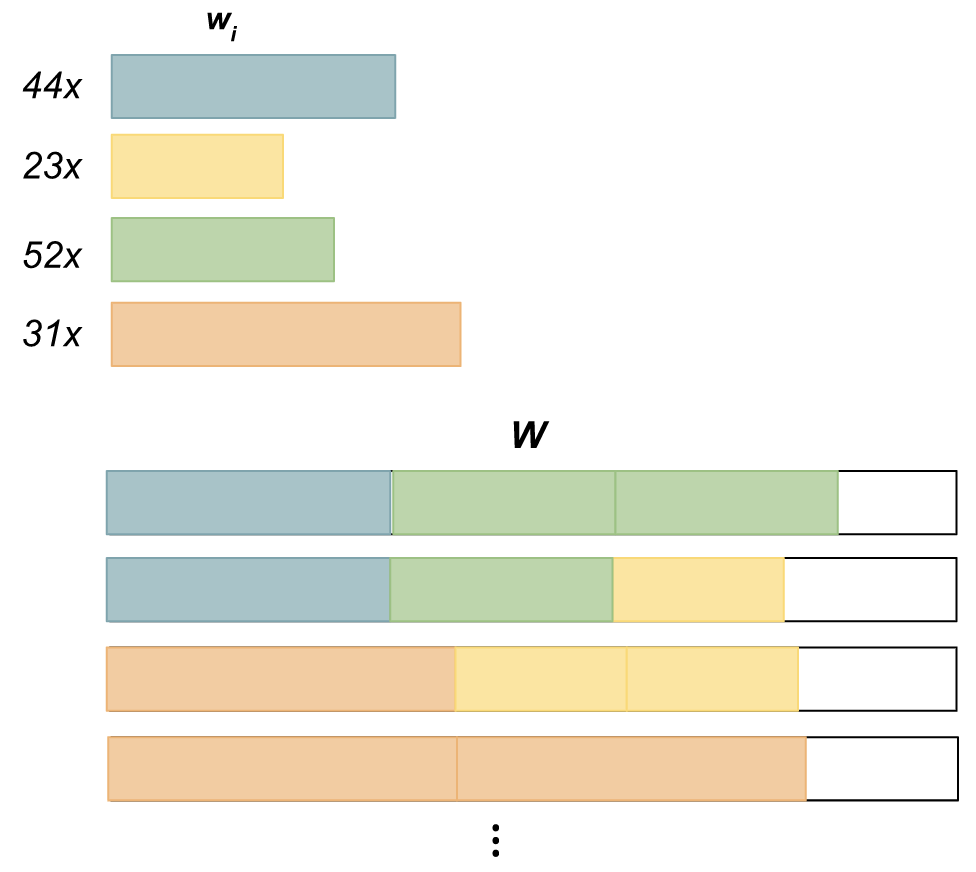 -->

Let $I$ be the set of patterns of cut that do not violate the max roll width: 

$I = \{i \in \mathbb{Z_+}^m : \sum_{j=1}^m w_ji_j \leq W\}$. The $i_j$ is the number of items from Order $j$ in Pattern $i$.

Let $I_R$ denote a subset of $I$. For exemple, for the patterns presented in the image above we have:

$I_R = \left\{\begin{bmatrix} 1\\2\\0\\0 \end{bmatrix}, \begin{bmatrix} 1\\1\\1\\0 \end{bmatrix}, \begin{bmatrix} 0\\0\\1\\1 \end{bmatrix}, \begin{bmatrix} 0\\0\\0\\2 \end{bmatrix}\right\}.$

Let the variable $x_i$ be the number of Pattern $i$ to be processed. Then, the problem can be formulated as follows:

$
\begin{eqnarray}
\begin{array}{rcl}
& \min & {\displaystyle \sum_{i \in I}} \left(W-{\displaystyle \sum_{j=1}^m} w_ji_j\right) x_i\\
& \text{s.t.}& {\displaystyle\sum_{i \in I}} i_jx_i \geq b_j, \quad j = 1, \cdots, m,\\
&            & x_i \in \mathbb{Z_+}, \quad i \in I.\\
\end{array}
\end{eqnarray}
$

Here, the objective is to minimize total waste.

### Generic problem
A straightforward generalization of the Cutting Stock problem is the following:

$(P)$
$
\begin{eqnarray}
\begin{array}{rcl}
& z=\min & {\displaystyle \sum_{i \in I}} c_ix_i\\
& \text{s.t.}& {\displaystyle\sum_{i \in I}} a_ix_i \geq b,\\
&            & x_i \in \mathbb{Z_+}, \quad i \in I.\\
\end{array}
\end{eqnarray}
$

Here, $a_i$ and $b$ are column vectors.

For every subset $I_R$ of $I$, we define the Restricted Master Problem *RMP* as the linear relaxation of $P$ over $I_R$.

$(RMP)$
$
\begin{eqnarray}
\begin{array}{rcl}
z_{RMP}=& \min & {\displaystyle \sum_{i \in I_R}} c_ix_i\\
& \text{s.t.}& {\displaystyle\sum_{i \in I_R}} a_ix_i \geq b,\\
& & x_i \geq 0.
\end{array}
\end{eqnarray}
$

The $(RMP)$ can be represented in a compact matricial notation as follows:

$
\begin{eqnarray}
\begin{array}{rcl}
z_{RMP}=& \min & c_Rx_R\\
& \text{s.t.}&  A_Rx_R \geq b.\\
\end{array}
\end{eqnarray}
$

Let $x_R^*$ and $\pi_R^*$ be the primal and the dual optimum solutions of $RMP$. 
Then, the strong duality for linear programming implies that: 
$$z_{RMP} = \pi_R^* b.$$

Let $z_{LP}$ be the optimum value of the linear relaxation of $P$ over $I$.

Note that we don't know $z_{LP}$ because we are assuming that $I$ is too large to be written explicitly.
Nevertheless, since $I_R \subseteq I$, the following inequality holds:
$$z_{LP} \leq z_{RMP}.$$

Therefore, we know that: 
$$z_{LP} \leq \pi_R^* b.$$ 
If we can find a set $I_R$ for which equality holds here, then we are done. In fact, if that is the case, then we can construct an optimal solution for the linear relaxation of $P$ from the optimal solution of $RMP$ (just set $x^*_i=0$ for all $i \notin I_R$).
But how do we know if inequality holds without knowing $z_{LP}$?

By weak duality, any feasible solution $\pi^*$ for the dual of the linear relaxation of $P$ satisfies:
$$\pi^*b \leq z_{LP}.$$

In particular, if all reduce costs $c_i-\pi_R^*a_i$, for all $i \in I$, is non-negative, then $\pi_R^*$ is dual feasible for the linear relaxation of $P$ and we are done!


Finally, to check whether all these reduced costs are non-negative, we need to solve the following pricing problem:

$(PP)$ $
\begin{eqnarray}
\begin{array}{rcl}
\sigma = & \min & c_i-\pi_R^*a_i\\
& \text{s.t.}&  i \in I\\
\end{array}
\end{eqnarray}
$

Here, the "generation" of the columns $a_i$ must be done implicitily over all $i \in I$.

As a result,
* if $\sigma \geq 0$ then $\pi_R$ is an dual optimum for the linear relaxation of $P$ and we are done.
* otherwise, the optimum solution of $PP$ is a candidate to be a new collumn for the $RMP$.

### Back to Cutting stock exemple:

The columns vectors $a_i$ is not explicitily available, but it is defined through the rule that defines $I$. 

Accordingly, considering the $m$ vector variable $y$, the $PP$ problem becomes

$
\begin{eqnarray}
\begin{array}{rcl}
\sigma = & \min & \left(W-{\displaystyle \sum_{j=1}^m} w_jy_j\right)-{\displaystyle \sum_{j=1}^m} \pi_j^*y_j\\
& \text{s.t.}& {\displaystyle \sum_{j=1}^m} w_jy_j \leq W\\
& & y_j \geq 0.\\
\end{array}
\end{eqnarray}
$ 

In [1]:
# Indexes of orders
m = 4
J = [k for k in range(m)]

# Data
W = 9
w = [4, 3, 2, 5]
b = [44, 23, 52, 31]

# W = 250  # bar length
# w = [187, 119, 74, 90]  # size of each item
# b = [1, 2, 2, 1]  # demand for each item

In [2]:
import mip

# Restricted Master Problem
master = mip.Model("RMP", solver_name=mip.CBC)
master.verbose = 0
## Here the set I is the restricted set of patterns.
I = [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
x = [master.add_var(var_type=mip.CONTINUOUS, name=f'x{i}') for i, array_i in enumerate(I)]
constraints = []
for j in J:
    constraints.append(master.add_constr(mip.xsum(pattern_i[j]*x[i] for i, pattern_i in enumerate(I)) >= b[j]))
master.objective = mip.minimize(mip.xsum((W-sum(pattern_i[j]*w[j] for j in J))*x[i] for i, pattern_i in enumerate(I)))

# Pricing Problem
pricing_problem = mip.Model("PP")
pricing_problem.verbose = 0
y = [pricing_problem.add_var(var_type=mip.INTEGER, name=f'y{j}') for j in J]
pricing_problem.add_constr(mip.xsum(w[j] * y[j] for j in J) <= W)


def get_new_pattern(master_dual_solution:list, pricing_problem:mip.Model, TO=1e-4):
    """
    :master_dual_solution: The dual solution of the RMP.
    :pricing_problem: The model for pricing problem.
    :TO: Tolerance.
    :return: A new collumn (pattern), or None if optimization criteria was met.
    """
    pricing_problem.objective = mip.maximize(mip.xsum((w[j]+master_dual_solution[j]) * pricing_problem.vars[j] for j in J))
    pricing_problem.optimize()
    price = W - pricing_problem.objective_value
    print('Price:', price)
    return None if price >= -TO else [pricing_problem.vars[j].x for j in J]

# Initialization
# master.relax()
master.optimize()
# print([var.x for var in x])
# print([x[i].x for i in I])
pi = [c.pi for c in master.constrs]
new_pattern = get_new_pattern(pi, pricing_problem)

#Column generation iterations
num_iter = 1
while new_pattern is not None and num_iter < 1000:
    I.append(new_pattern)
    column = mip.Column(constraints, new_pattern)
    v = master.add_var(
        var_type=mip.CONTINUOUS, obj=(W-sum(new_pattern[j]*w[j] for j in J)), column=column, name=f'x{len(x) + 1}')
    x.append(v)
    print("Quantity of columns:", len(x))
    master.optimize()
    pi = [c.pi for c in constraints]
    new_pattern = get_new_pattern(pi, pricing_problem)
    num_iter += 1

# In case the solution is not integer, we should branch and bound.
# The following lines are workaround the get an interger solution over the generated columns.
is_integer = True
for var in x:
    if var.x != int(var.x):
        is_integer = False
if not is_integer:
    for var in master.vars:
        var.var_type = mip.INTEGER
    print(master.optimize())

print("------------\nResults:")
print("Number of interations =", num_iter)
print("Objective value =", master.objective_value)
print("Quantity of rolls =", sum([var.x for var in x]))
for i, array_i in enumerate(I):
    if x[i].x > 0:
        print(x[i], x[i].x, array_i)


Price: -27.0
Quantity of columns: 5
Price: -18.0
Quantity of columns: 6
Price: -9.0
Quantity of columns: 7
Price: -4.5
Quantity of columns: 8
Price: -0.75
Quantity of columns: 9
Price: 0.0
OptimizationStatus.OPTIMAL
------------
Results:
Number of interations = 6
Objective value = 0.0
Quantity of rolls = 64.0
x6 2.0 [0.0, 3.0, 0.0, 0.0]
x8 44.0 [1.0, 0.0, 0.0, 1.0]
x9 18.0 [0.0, 1.0, 3.0, 0.0]


### Comparing objectives: minimum waste and minimum quantity of rolls

In [3]:
import copy
solution_min_quantity = [1, 2, 21, 23, 10]
patterns_min_quantity = [[0, 0, 1, 0], [0, 0, 4, 0], [1, 0, 0, 1],[1, 1, 1, 0],[0, 0, 2, 1]]
solution_min_waste = [2, 44, 18]
patterns_min_waste = [[0, 3, 0, 0], [1, 0, 0, 1], [0, 1, 3, 0]]
# solution_min_min = [20, 7, 6, 24]
# patterns_min_min = [[1, 1, 1, 0], [0, 0, 2, 1], [0, 1, 3, 0], [1, 0, 0, 1]]
solution_min_min = [2, 7, 31, 18]
patterns_min_min = [[0, 3, 0, 0], [2, 0, 0, 0], [1, 0, 0, 1], [0, 1, 3, 0]]


min_min = 0
over_demand_min_min = [-v for v in b]
for k, qtd in enumerate(solution_min_min):
    pattern = patterns_min_min[k]
    min_min += W
    for i, q in enumerate(pattern):
        min_min -= q*w[i]
        over_demand_min_min[i] += qtd*q 

waste_min_quantity = 0
over_demand_min_quantity = [-v for v in b]
for k, qtd in enumerate(solution_min_quantity):
    pattern = patterns_min_quantity[k]
    waste_min_quantity += W
    for i, q in enumerate(pattern):
        waste_min_quantity -= q*w[i]
        over_demand_min_quantity[i] += qtd*q 
    
waste_min_waste = 0
over_demand_min_waste = [-v for v in b]
for k, qtd in enumerate(solution_min_waste):
    pattern = patterns_min_waste[k]
    waste_min_waste += W
    for i, q in enumerate(pattern):
        waste_min_waste -= q*w[i]
        over_demand_min_waste[i] += qtd*q
print(sum(solution_min_quantity), waste_min_quantity, over_demand_min_quantity)
print(sum(solution_min_waste), waste_min_waste, over_demand_min_waste)
print(sum(solution_min_min), min_min, over_demand_min_min)

57 8 [0, 0, 0, 0]
64 0 [0, 1, 2, 13]
58 1 [1, 1, 2, 0]


|            |rolls_qtt | total_waste | over_demand |
|------------|----------|-------------|-------------|        
|min_qtt     |   57     |    8        |\begin{bmatrix} 0, 0, 0, 0 \end{bmatrix}|
|min_waste   |   64     |    0        |\begin{bmatrix} 0, 1, 2, 13 \end{bmatrix}| 
|min_min     |   57     |    0        |\begin{bmatrix} 0, 3, 0, 0 \end{bmatrix}| 

### Two variable model for cutting stock problem.

In [12]:
import mip
# Max quantity of rools
q = 57

# Creating the model
model = mip.Model("cutting_stock", solver_name=mip.CBC)
model.verbose = 0

# Variables
## Quantity of demand j in roll i.
x = {(i, j): model.add_var(var_type=mip.INTEGER, name=f'xi{i}j{j}')
     for j in J for i in range(q)}
## 1 if roll i is used.
y = {i: model.add_var(var_type=mip.BINARY, name="y[%d]" % i)
     for i in range(q)}
# aux variable: waste in each roll i.
z = {i: model.add_var(var_type=mip.BINARY, name="z[%d]" % i)
     for i in range(q)}

# Constraints
## Meet demand
for j in J:
    c = model.add_constr(mip.xsum(x[i, j] for i in range(q)) >= b[j])
## Length of rolls.
for i in range(q):
    c = model.add_constr(mip.xsum(w[j] * x[i, j] for j in J) + z[i] == W * y[i] )
# Additional constraints to reduce symmetry
# for i in range(1, q):
#     model.add_constr(y[i - 1] >= y[i])

# Objective value: minimize waste
model.objective = mip.minimize(mip.xsum(z[i] for i in range(q)))

# model.write('model.lp')

# optimizing the model
print(model.optimize())

# printing the solution
print(model.objective_value)
patterns = {}
for i in range(0, q):
    pattern = []
    for j in J:
        if y[i].x > 0:
            pattern.insert(j, x[i, j].x)
    pattern_key = str(pattern[0])
    for k in range(1, len(pattern)):
        pattern_key += '-' + str(pattern[k])
    qtt = patterns.setdefault(pattern_key, 0)
    patterns[pattern_key] = qtt + 1

for pattern, qtt in patterns.items():
    print(qtt, pattern.split('-'))


OptimizationStatus.OPTIMAL
0.0
20 ['1.0', '1.0', '1.0', '0.0']
7 ['0.0', '0.0', '2.0', '1.0']
6 ['0.0', '1.0', '3.0', '0.0']
24 ['1.0', '0.0', '0.0', '1.0']


In [66]:
22 + 9 + 20 + 1 + 3 + 1 + 1

57

In [67]:
20 +7 + 6 + 24

57

In [12]:
x2 1   [0, 0, 1, 0]
x5 2   [0, 0, 4, 0]
x8 21  [1, 0, 0, 1]
x9 23  [1, 1, 1, 0]
x10 10 [0, 0, 2, 1]

9

In [13]:
w

[4, 3, 2, 5]

In [19]:
J

[0, 1, 2, 3]

In [23]:
b

[44, 23, 52, 31]